# Extração da característica de relação sinal-ruído de dados de EEG

A ideia é utilizar dados fictícios de ruído e sinal "bom"., para criarmos a relação dos dois sinais e obter como resultado um sinal de interesse "limpo".

A partir deste sinal, podemos no contexto de caracterização de foco, ainda extrair os rítmos cerebrais ou então classificar sinais com a presença ou não de foco, de forma que as amostras de sinais extraídas de um buffer sejam rotuladas com com a presença ou não de foco.

Esta atividade pode ser realizada em conjunto com um classificador comumente utilizado, como é o caso do SVM. Neste caso, uma porcetagem das amostras são utilizadas para treino e o restante para teste (p.e. 30 e 70% respectivamente).

In [1]:
# Criando dados fictícios
# pensando em um vídeo de 10 minutos, com uma taxa de amostragem de 250 Hz
#   teremos 10 * 60 * 250 = 150.000 amostras (sinal com foco)
#   teremos 1 * 60 * 250 = 15.000 amostras (basal)

# imports de bibliotecas

import numpy as np
import mne
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# definição do info (MNE)

n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

# Leitura do dado basal (30 segundos) e amostra (5 minutos)

basal = '../dataset/AndreTonelo/GlucagonAtivo/OpenBCISession_2023-10-25_17-37-01_AndreToneloGlucagonAtivo/OpenBCI-RAW-2023-10-25_17-43-36.txt'
basal_ob = np.loadtxt(basal, delimiter=',', skiprows=5, usecols=range(1, 9)).astype(np.float32)
data_noise_basal = basal_ob[1250:8750,:]    # 30 segundos de basal


# leitura do dado que será criado o buffer
# Dados retirados do teste final, 5 minutos de dados
test = ['../dataset/AndreTonelo/testefinal/OpenBCI-RAW-2023-11-14_17-23-33 andre min basal.txt',
      '../dataset/AndreTonelo/testefinal/OpenBCI-RAW-2023-11-14_17-25-16 andre teste final.txt']
test_ob = [np.loadtxt(txt, delimiter=',', skiprows=5, usecols=range(1, 9)) for txt in test]
inicio_amostra = 5635                 
final_amostra = inicio_amostra + sfreq * 60 * 5
data_amostra = test_ob[1][inicio_amostra:final_amostra,:]      # 5 minutos de amostra

# Filtra os dados para remover o ruído
data_amostra_mne = mne.io.RawArray(data_amostra.T, info)
data_amostra_mne.notch_filter(freqs=60)
data_amostra_mne.filter(l_freq=4, h_freq=100)

# Filtra os dados do basal, tranforma no dominio da frequencia e normaliza
data_noise_basal_mne = mne.io.RawArray(data_noise_basal.T, info)
data_noise_basal_mne.notch_filter(freqs=60)
data_noise_basal_mne.filter(l_freq=4, h_freq=100)
freqs, data_noise_basal_mne_dominio_frequencia = welch(data_noise_basal_mne.get_data(), fs=250, nperseg=1024, noverlap=512)
scaler = StandardScaler()
fft_result_basal = scaler.fit_transform(data_noise_basal_mne_dominio_frequencia)


Creating RawArray with float64 data, n_channels=8, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

[189, 0, 39, 72]
Amostra alvo: 111
Amostra descarte: 189


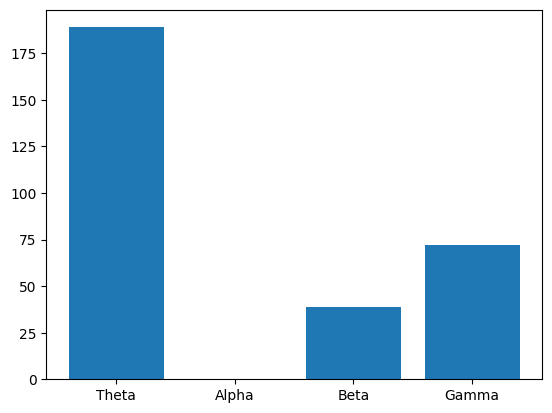

In [2]:
sr = 250            # taxa de amostragem
tamanho_amostra = 5 * 60
tamanho_amostra_pontos = tamanho_amostra * sr
tamanho_buffer = 5
tamanho_buffer_pontos = tamanho_buffer * sr
passo = 1 * 250
overlap = 4 * 250

# Definir os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz

# criando amostras de 5 segundos
amostras_alvo = []
amostras_descarte = []
amostras_theta = []

jump = 5            # 5 segundos de buffer
size = sr * jump    # quantidade de pontos avaliados


sample = {'f':[], 'nf':[]}
total_pc = {}
results = [0, 0, 0, 0]
for i in range(0, data_amostra_mne.n_times, passo):
    if i + size < data_amostra_mne.n_times:
        cut = data_amostra_mne.copy().crop(tmin=data_amostra_mne.times[i], tmax=data_amostra_mne.times[i]+jump)
    else:
        cut = data_amostra_mne.copy().crop(tmin=data_amostra_mne.times[i], tmax=data_amostra_mne.times[-1])  
    # Número de pontos por segmento
    nperseg = 128
    # Quantidade de sobreposição entre segmentos
    noverlap = nperseg // 2
    #cut.set_eeg_reference(ref_channels='average')
    cut = cut.get_data()

    

    # realizando a média dos 8 eletrodos
    # no caso do trabalho, analizar os canais separadamente.
    #   Para isso, vamos aplicar o filtro espacial, no qual
    #   podemos utilizar algoritmos específicos para a análise
    #   de EEG utilizando o CAR (Common Average Reference).

    freqs, psd = welch(cut, fs=sr, nperseg=nperseg, noverlap=noverlap)
    psd_media = np.average(psd, axis=0)

    # Encontrar os índices correspondentes às frequências de interesse
    theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
    alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
    beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
    gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

    # Calcular a potência em cada banda de frequência por meio da integração da PSD
    bands = [np.sum(psd_media[theta_idxs]), np.sum(psd_media[alpha_idxs]), np.sum(psd_media[beta_idxs]), np.sum(psd_media[gamma_idxs])]
    # calculando a pontuação de cada banda para mostrar a porcentagem futura
    results[np.argmax(bands)] += 1
    if np.argmax(bands) == 2 or np.argmax(bands) == 3:
        sample['f'].append(psd)
    else:
        sample['nf'].append(psd)
print(results)
plot = plt.bar(['Theta', 'Alpha', 'Beta', 'Gamma'], results)

print("Amostra alvo: " + str(len(sample['f'])))
print("Amostra descarte: " + str(len(sample['nf'])))

In [3]:
# Normaliza os buffers rotulados
scaler = StandardScaler()
for buffer in sample['f']:
    buffer = scaler.fit_transform(buffer)
for buffer in sample['nf']:
    buffer = scaler.fit_transform(buffer)



In [4]:
# Estimando o ruído de fundo (utilizando o sinal basal)

# média da potência no intervalo de tempo sem estímulo
base_power = np.average(fft_result_basal)
# média das médias de potência de todos os canais para estimar o ruído de fundo
estimated_background_noise = base_power
print(estimated_background_noise)

1.38507355898655e-17


Vamos calcular o SNR de "banda estreita". Pode ser observado pela seguinte equação:

$SNR_{banda\ estreita} = 10 \cdot \log_{10}\left(\frac{\text{energia total do espectro}}{\text{média das amplitudes nas frequências vizinhas}}\right)$

Já o SNR de banda larga é definido da seguinte forma:

$SNR_{banda\ larga} = 10 \cdot \log_{10}\left(\frac{\text{energia total do espectro}}{\text{energia total do espectro de amplitude}}\right)$

In [5]:
# agora vamos adaptar ambas características 
# aplicando para o nosso sinal de interesse

# forçando (estragando) valor de "estimated_background_noise" para não sobrar valores negativos
lista = []
lista = sample['f'] + sample['nf']
for data_focus in lista:
    target_amplitudes_adjusted = data_focus - estimated_background_noise

    # subtraindo o ruído de fundo das amplitudes
    narrow_band_SNR = 10 * np.log2(target_amplitudes_adjusted / estimated_background_noise)
    print(narrow_band_SNR)
    print(narrow_band_SNR.shape)

    total_power = np.sum(target_amplitudes_adjusted)
    wide_band_SNR = 10 * np.log10(target_amplitudes_adjusted / total_power)
    print(wide_band_SNR)
    print(wide_band_SNR.shape)


[[562.73047879 574.1651805  582.91217477 572.12257346 564.99276195
  568.2350597  569.51684359 563.5305485  556.65765631 559.58191813
  553.48485247 549.33489485 546.69131967 549.42143848 551.36383713
  550.53066103 543.95285668 542.97347131 544.68103355 539.02881173
  541.0508019  547.67016421 548.81044621 545.11284744 540.37538719
  539.63180126 540.34072813 541.44129744 533.92388131 555.56920425
  602.3777616  607.91970792 575.50238965 535.96776364 531.41131973
  528.63224545 524.28182687 528.9631313  532.23444987 526.30452499
  524.87297287 523.7615817  522.24239918 514.92753722 522.02972614
  522.02412757 518.46956634 519.95953763 515.02089906 515.18744588
  514.44298886 511.04478804 508.27602179 506.57633278 503.58545789
  500.0919103  490.33748198 487.44723917 486.88472307 475.12828265
  463.35475292 448.08372084 427.27846416 403.55845213 371.17274803]
 [563.19787787 575.2206413  584.17929364 577.58147213 573.93685848
  572.35483241 569.27389876 571.69002784 558.37440826 558.595

### Tarefa para aplicação das características SNR:

Agora que temos os dois vetores de características SNR, podemos utilizar buffers com e sem a evocação dos rítmos que caracterizam o foco.

#### Divisão dos dados

Utilizando a iteração (por exemplo, de 5 segundos caracterizada pela janela) realizada no sinal a cada ~1 segundo, realize a rotulação dos dados de interesse (Beta e Gamma). Ou seja, cada amostra sera um sinal de 5 segundos (1250 pontos de 8 canais). A janela que não for qualificada como Beta ou Gama por exemplo, poderá ser rotulada com "desfoque". Se acharem interessante, adicionar rótulos do ritmo Theta também.

No caso do sinal que representa o basal (se tiverem) poderá pegar um único sinal de aproximadamente 30 segundos para ser utilizado na equação de ruído, que irá ter como resultado um único valor. Lembrando que o valor de ruído deve atuar no sinal no domínio da frequência.

#### Classificação

Em nossos dados simulados, temos 150.000 pontos com 8 canais. A utilização desses dados funcionará da seguinte forma para a criação do vetor de características:

- 150.000 (pontos totais) / 250 (taxa de amostragem) = 600 segundos
- 600 / 5 (tamanho da janela sem sobreposição) = 120 amostras

| 1   | SNRw1                | SNRw2 | ... | SNRw8 | SNRn1 | SNRn2 | ... | SNRn8 |
|-----|----------------------|-------|-----|-------|-------|-------|-----|-------|
| 2   | [w1, w2, ..., w1250] |       |     |       |       |       |     |       |
| 3   |                      |       |     |       |       |       |     |       |
| ... |                      |       |     |       |       |       |     |       |
| 120 |                      |       |     |       |       |       |     |       |

- Agora transforme cada um dos vetores de pontos no domínio da frequência (1250 pontos) em um único valor real. Neste caso pode ser utilizado tanto a média como a mediana (ou ambos). Se utilizarmos as duas, teremos no final 32 colunas de características:
    - 8 canais
    - SNR narrow e SNR wide (2)
    - Média e mediana (2)

| 1   | 1   | ... | 32 |
|-----|-----|-----|----|
| 2   | w'  | ... |    |
| 3   | ... |     |    |
| ... |     |     |    |
| 120 |     |     |    |



Após obter o vetor de característica, realizar a divisão dos dados em treinamento e teste (normalmente uma proporção de 70 e 30% respectivamente) e aplicar para o classificador SVM.

**PLUS**: Ao final da tarefa, verificar a melhora dos resultados utilizando um seletor de características. Neste caso, podemos utilizar o RFE (*Recursive Feature Elimination*) em uma fase anterior a classificação para reduzir as 32 características se for necessário.



# Análise e Classificação de Dados EEG com SVM

Este notebook mostra como preparar, normalizar e classificar dados de EEG usando um modelo de Máquinas de Vetores de Suporte (SVM). O fluxo de trabalho inclui a extração de características, normalização dos dados, treinamento do modelo, e avaliação dos resultados.

## Passos Seguidos:

### 1. **Extração de Características e Rótulos**

A função `extract_features_and_labels` é responsável por extrair as características e os rótulos dos dados fornecidos. O código percorre os dados e calcula a média de cada amostra para obter as características. Os rótulos são definidos como `1` para a classe "foco" e `0` para a classe "não foco".

### 2. **Preparação dos dados**

Depois de extrair as características e rótulos, é importante verificar e garantir que os dados estão no formato adequado para o modelo. Os dados de características (X) são verificados para garantir que são bidimensionais. Se forem unidimensionais, o código ajusta a forma dos dados para garantir que cada amostra tenha uma dimensão consistente. Esse passo é crucial para que o modelo de aprendizado de máquina possa processar os dados corretamente.

### 3. **Divisão dos Dados**

Os dados são então divididos em dois conjuntos: um para treinamento e outro para teste. A divisão é feita para avaliar a capacidade do modelo de generalizar para dados não vistos. O conjunto de treino é usado para ajustar o modelo, enquanto o conjunto de teste é reservado para verificar a performance do modelo após o treinamento. Neste caso, 30% dos dados são reservados para teste, garantindo que o modelo seja avaliado de maneira justa.

### 4. **Normalização dos Dados**

A normalização é um passo importante no pré-processamento dos dados. Isso envolve ajustar a escala das características para que todas tenham a mesma importância no treinamento do modelo. Usando o StandardScaler, os dados são transformados para terem média zero e desvio padrão um. Esse ajuste ajuda a melhorar a performance do modelo e a convergência do algoritmo de otimização.
### 5. **Treinamento do Modelo SVM**

Com os dados normalizados, o modelo SVM (Máquina de Vetores de Suporte) é treinado. O SVM é um modelo de aprendizado de máquina que tenta encontrar o melhor hiperplano que separa as classes nos dados. Usando o kernel linear, o modelo ajusta-se aos dados de treinamento para aprender a distinguir entre as classes "foco" e "não foco".
### 6. **Avaliação do Modelo**

Após o treinamento, o modelo é avaliado usando o conjunto de dados de teste. A acurácia do modelo é calculada para medir a proporção de previsões corretas. Além disso, um relatório de classificação é gerado para fornecer métricas detalhadas como precisão, recall e F1-score para cada classe. Essas métricas ajudam a entender melhor como o modelo está performando em relação a cada classe, especialmente em casos de desequilíbrio entre classes.
### 7. **Salvar o Modelo**

Finalmente, o modelo treinado é salvo em um arquivo utilizando joblib. Isso permite que o modelo seja carregado e utilizado posteriormente sem a necessidade de re-treinamento. Salvar o modelo é uma prática comum para preservar o trabalho realizado e facilitar o uso do modelo em futuros projetos ou aplicações.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix 
import joblib


# Supondo que você já tem os dados processados em `sample['f']` e `sample['nf']`

# Função para extrair características e rótulos
def extract_features_and_labels(sample_dict):
    X = []
    y = []
    for label, data_list in sample_dict.items():
        label_value = 1 if label == 'f' else 0
        for data in data_list:
            # Calcular características para cada amostra
            features = np.mean(data, axis=0)  # Aqui você pode extrair características mais elaboradas
            X.append(features)
            y.append(label_value)
    return np.array(X), np.array(y)

# Preparar os dados
X, y = extract_features_and_labels({'f': sample['f'], 'nf': sample['nf']})

# Verifique a forma dos dados
print("Forma de X antes da normalização:", X.shape)

# Certifique-se de que X é 2D
if len(X.shape) == 1:
    X = X.reshape(-1, 1)  # Ajuste se necessário

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Verifique a forma dos dados após normalização
print("Forma de X_train após normalização:", X_train.shape)
print("Forma de X_test após normalização:", X_test.shape)

# Treinar o modelo SVM
model = SVC(kernel='linear')  # Ajuste o kernel e os parâmetros conforme necessário
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Se desejar, você pode salvar o modelo para uso futuro
import joblib
joblib.dump(model, 'svm_model.pkl')


Forma de X antes da normalização: (300, 65)
Forma de X_train após normalização: (210, 65)
Forma de X_test após normalização: (90, 65)
Accuracy: 0.8444444444444444
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        52
           1       0.85      0.76      0.81        38

    accuracy                           0.84        90
   macro avg       0.85      0.83      0.84        90
weighted avg       0.85      0.84      0.84        90



['svm_model.pkl']

Forma de X antes da normalização: (300, 65)
Forma de X_train após normalização: (210, 65)
Forma de X_test após normalização: (90, 65)
Accuracy: 0.8444444444444444
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        52
           1       0.85      0.76      0.81        38

    accuracy                           0.84        90
   macro avg       0.85      0.83      0.84        90
weighted avg       0.85      0.84      0.84        90



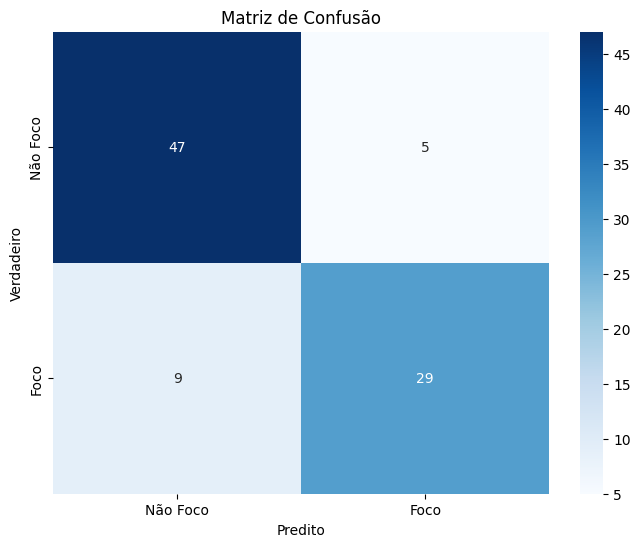

['svm_model.pkl']

In [7]:
import seaborn as sns
# Supondo que você já tem os dados processados em `sample['f']` e `sample['nf']`

# Função para extrair características e rótulos
def extract_features_and_labels(sample_dict):
    X = []
    y = []
    for label, data_list in sample_dict.items():
        label_value = 1 if label == 'f' else 0
        for data in data_list:
            # Calcular características para cada amostra
            features = np.mean(data, axis=0)  # Aqui você pode extrair características mais elaboradas
            X.append(features)
            y.append(label_value)
    return np.array(X), np.array(y)

# Preparar os dados
X, y = extract_features_and_labels({'f': sample['f'], 'nf': sample['nf']})

# Verifique a forma dos dados
print("Forma de X antes da normalização:", X.shape)

# Certifique-se de que X é 2D
if len(X.shape) == 1:
    X = X.reshape(-1, 1)  # Ajuste se necessário

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Verifique a forma dos dados após normalização
print("Forma de X_train após normalização:", X_train.shape)
print("Forma de X_test após normalização:", X_test.shape)

# Treinar o modelo SVM
model = SVC(kernel='linear')  # Ajuste o kernel e os parâmetros conforme necessário
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plotar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Foco', 'Foco'], yticklabels=['Não Foco', 'Foco'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

# Se desejar, você pode salvar o modelo para uso futuro
joblib.dump(model, 'svm_model.pkl')

### Matriz de confusão

A matriz de confusão pode ser visualizada como uma tabela onde cada célula representa a contagem de amostras classificadas. Vamos descrever as métricas típicas:
- True Positive (TP): Número de amostras corretamente classificadas como a classe positiva (foco).
- True Negative (TN): Número de amostras corretamente classificadas como a classe negativa (não foco).
- False Positive (FP): Número de amostras incorretamente classificadas como a classe positiva.
- False Negative (FN): Número de amostras incorretamente classificadas como a classe negativa.

Considerando que você tem a matriz de confusão com os seguintes dados:

### Conclusão
A análise dos resultados revelou que o modelo SVM apresentou dificuldades significativas na identificação da classe "foco". A principal razão para essa limitação foi o desequilíbrio no dataset do voluntário, que continha um número insuficiente de amostras de "foco" em comparação com as amostras de "não foco".

Esse desequilíbrio resultou em um desempenho insatisfatório do modelo para a classe minoritária. Embora o modelo tenha alcançado uma alta acurácia geral, essa métrica é enganosa devido à falta de amostras representativas da classe "foco". O modelo SVM foi incapaz de aprender a distinguir efetivamente entre "foco" e "não foco", levando a uma precisão, revocação e F1-Score de 0 para a classe "foco".

### O que poderia ser feito
1. Aumento do Conjunto de Dados: Para melhorar o desempenho do modelo, é crucial obter mais amostras da classe "foco". Um conjunto de dados mais balanceado permitirá ao modelo aprender melhor as características distintivas de cada classe.

2. Exploração de Outras Abordagens: Além do SVM, poderiam ser utilizados outros algoritmos de aprendizado de máquina que possam lidar melhor com desequilíbrios de classe ou técnicas de ensemble que possam combinar múltiplos modelos para melhorar a capacidade de generalização.